# An Introduction to LROSE

<img align="right" width="200" height="200" src="../images/colette_rose.jpg">
<img align="right" width="200" height="200" src="../images/LROSE_logo_small.png">
    
The Lidar Radar Open Software Environment (LROSE) is an National Science Foundation (NSF) supported project to develop common software for the Lidar, Radar, and Profiler community based on collaborative, open source development.  The core package is being jointly developed by Colorado State University (CSU) and the Earth Observing Laboratory at the NSF National Center for Atmospheric Research (NSF NCAR/EOL). The current LROSE release is called Colette (a versatile climbing rose). 

More information on LROSE can be found on the [LROSE wiki](http://wiki.lrose.net/index.php/Main_Page).


## Notebook Summary

This notebook will cover the following:

1. LROSE Overview
2. LROSE on the Command Line
3. LROSE Parameter Files
4. Inspect the Data
5. Format Conversion
6. Simple Gridding
7. Basic Data Display

## LROSE Overview

LROSE encompasses six key toolsets that define a core lidar/radar workflow: Convert, Display, QC, Grid, Echo, and Winds. Colette focuses on high-quality, well-tested, well-maintained and well-documented key applications as ‘building blocks’, allowing users to assemble trusted, reproducible workflows to accomplish more complex scientific tasks.

### Installation

LROSE is available for download through [GitHub](https://github.com/NCAR/lrose-core/). Installation is supported for Linux (source, packages) and Mac OS (source, Homebrew). Conda-forge development is underway.

### LROSE Tutorials

We're developing a Science Gateway where LROSE tools are installed on NSF's Jetstream2 supercomputer. The tutorials from that Gateway can also be found on GitHub. 

https://github.com/nsf-lrose/lrose-hub

### Issues?

For problems running LROSE or general questions, please reach out on the LROSE [forum](http://forum.lrose.net/). 

Please submit bugs on [GitHub](https://github.com/NCAR/lrose-core/). 

### Listserv

We maintain a listserv to alert the LROSE community of new LROSE releases, workshops, and other general communication. Email traffic is generally minimal.

https://lists.colostate.edu/cgi-bin/mailman/listinfo/lrose-users

### Initialize python

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import fsspec
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
import xarray as xr
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Set directory variable to call LROSE
os.environ["LROSE_DIR"] = "/usr/local/lrose/bin"

# Set the URL and path to access the data on the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = f"pythia/radar/erad2024"

fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/*")

files = fs.glob(
    f"{path}/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/*.nc"
)  #### FIX PATH
local_files = [
    fsspec.open_local(
        f"simplecache::{URL}{i}", s3={"anon": True}, filecache={"cache_storage": "."}
    )
    for i in files
]

In [3]:
files[0]

'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221300.nc'

In [4]:
# create a directory
!mkdir -p ./raw

# LROSE prefers files to have .nc extension, so create a softlink with the actual filename
# We'll use the first file as an example!
os.system("ln -sf " + local_files[0] + " ./raw/" + files[0].split("/")[-1])

0

In [5]:
!pwd

/home/jovyan/notebooks/lrose


## LROSE on the Command Line

Each LROSE application has different command line options for running. To see all the available options, use the ```-h``` flag.


```
  RadxPrint -h
```


In [6]:
# view the command line options
!${LROSE_DIR}/RadxPrint -h

Usage: RadxPrint [args as below]
Options:

  [ -h ] produce this list.

  [ -ag ] aggregate sweep files into volume on read
          applies to DORADE and CFRADIAL sweep files

  [ -ag_all ] aggregate files in input list on read.
          ALL FILES in the input list are aggregated into a volume.
          See '-f' option.

  [ -ang ? ] set single fixed angle
             or minimum - see '-ang_max'

  [ -ang_max ? ] set max fixed angle
                 use '-ang' for setting minimum

  [ -apply_georefs] apply georeference corrections on read.
      For moving platforms, measured georeference information is
      somtimes available.
      If so, this is applied and appropriate corrections made.
      Earth-centric azimuth and elevation angles will be computed.

  [ -change_lat_sign] change the sign of the radar latitude
    Useful for RAPIC files that always have a positive latitude.

  [ -const_ngates ] force number of gates constant for all rays
                    Added gates will 

## LROSE Parameter Files

All LROSE applications have a detailed parameter file, which is read in at startup. The parameters allow the user to control the processing in the LROSE apps. To generate a default parameter file, you use the -print_params option for the app.

For example, for RadxConvert you would use:

```
  RadxConvert -print_params > RadxConvert.nexrad
```

and then edit RadxConvert.nexrad appropriately.

At runtime you would use:

```
  RadxConvert -params RadxConvert.nexrad ... etc ...
```

In [7]:
# view the default parameters
!${LROSE_DIR}/RadxPrint -print_params

/**********************************************************************
 * TDRP params for /usr/local/lrose/bin/RadxPrint
 **********************************************************************/

//======================================================================
//
// Prints out radial RADAR/LIDAR data.
//
//======================================================================
 
//======================================================================
//
// DEBUGGING.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
//
// If set, debug messages will be printed appropriately.
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA

debug = DEBUG_OFF;

//======================================================================
//
// DATA RETRIEVAL CONTROL.
//
//======================================================================
 
/

In [8]:
# save the default parameters to a file
!${LROSE_DIR}/RadxPrint -print_params > ./RadxPrint_params

# if you have an existing parameter file and want to update it (e.g., a new LROSE version is released),
# you could run a command similar to the following, just update the parameter file names
# !${LROSE_DIR}/RadxPrint -f ./path/to/RadxPrint_params -print_params > ./RadxPrint_params_new

HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5P.c line 1485 in H5Pclose(): not a property list
    major: Invalid arguments to routine
    minor: Inappropriate type
PropList::~PropList - H5Pclose failed
HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5P.c line 1485 in H5Pclose(): not a property list
    major: Invalid arguments to routine
    minor: Inappropriate type
PropList::~PropList - H5Pclose failed
HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5P.c line 1485 in H5Pclose(): not a property list
    major: Invalid arguments to routine
    minor: Inappropriate type
PropList::~PropList - H5Pclose failed
HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5P.c line 1485 in H5Pclose(): not a property list
    major: Invalid arguments to routine
    minor: Inappropriate type
PropList::~PropList - H5Pclose failed
HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 1:
  #000: H5P.c line 1485 in H5Pclose(): not a property list
    majo

In [9]:
# View the param file
!cat ./RadxPrint_params

/**********************************************************************
 * TDRP params for /usr/local/lrose/bin/RadxPrint
 **********************************************************************/

//======================================================================
//
// Prints out radial RADAR/LIDAR data.
//
//======================================================================
 
//======================================================================
//
// DEBUGGING.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
//
// If set, debug messages will be printed appropriately.
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA

debug = DEBUG_OFF;

//======================================================================
//
// DATA RETRIEVAL CONTROL.
//
//======================================================================
 
/

## Inspect the Data

RadxPrint can print out file metadata, information about the variables, and other data. It's an alternative to ncdump, depending on the information you want.

In [10]:
# Print the metadata for the file we linked to earlier (-f flag links to files)
!${LROSE_DIR}/RadxPrint -f ./raw/*.nc

WARNING - NcfRadxFile::_readPositionVariables
 latitude should be type double
WARNING - NcfRadxFile::_readPositionVariables
 longitude should be type double
WARNING - NcfRadxFile::_readPositionVariables
 altitude should be type double


=============== RadxVol ===============
  convention: CF/Radial instrument_parameters
  version: 1.3
  title: 
  institution: 
  references: 
  source: 
  history: 
  comment: 
  volNum: 0
  scanName: 
  scanId(VCP): 0
--------------- RadxPlatform ---------------
  instrumentName: L
  siteName: 
  instrumentType: radar
  platformType: fixed
  primaryAxis: axis_z
  latitudeDeg: 46.0408
  longitudeDeg: 8.83322
  altitudeKm: 1.626
  sensorHtAglM: 0
  frequencyHz: 5.45077e+09
  radarAntGainDbH: -9999
  radarAntGainDbV: -9999
  radarBeamWidthDegH: 1
  radarBeamWidthDegV: 1
  radarReceiverBandwidthMhz: 6.90881e-316
--------------------------------------------
  rhiMode? N
  startTimeSecs: 2024/05/22 12:55:01
  startNanoSecs: 0
  endTimeSecs: 2024/05/22 12:59:44
  endNanoSecs: 9.5e+08
  NOTE: ray times are NOT in increasing order
  n sweeps: 20
  n rays: 7200
  n calibs: 0


  n fields: 9
    field[0]: reflectivity
    field[1]: signal_to_noise_ratio
    field[2]: reflectivity_vv
    field[3]: differential_reflectivity
    field[4]: uncorrected_cross_correlation_ratio
    field[5]: uncorrected_differential_phase
    field[6]: velocity
    field[7]: spectrum_width
    field[8]: reflectivity_hh_clut
  RadxRangeGeom:
    rangeGeomSet: Y
    startRangeKm: 0.249999
    gateSpacingKm: 0.499984
  RadxPacking: data packing
    nRays: 7200
    nPoints: 3542400
    maxNGates: 492
    nGatesVary: N
=============== RadxSweep ===============
  volNum: 0
  sweepNum: 0
  nRays: 360
  startRayIndex: 0
  endRayIndex: 359
  sweepMode: azimuth_surveillance
  polarizationMode: not_set
  prtMode: not_set
  followMode: not_set
  fixedAngle: -0.192264
  targetScanRate: -9999
  measuredScanRate: -5983.18
  raysAreIndexed: Y
  angleRes: 1
=============== RadxSweep ===============
  volNum: 0
  sweepNum: 1
  nRays: 360
  startRayIndex: 360
  endRayIndex: 719
  sweepMode: azimuth_su

PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed


In [11]:
# Examine ray-specific metadata
!${LROSE_DIR}/RadxPrint -summary -f ./raw/*.nc | tail -200

WARNING - NcfRadxFile::_readPositionVariables
 latitude should be type double
WARNING - NcfRadxFile::_readPositionVariables
 longitude should be type double
WARNING - NcfRadxFile::_readPositionVariables
 altitude should be type double


PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed


Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.170  40.00 160.52 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.170  40.00 161.53 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.240  40.00 162.52 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.240  40.00 163.52 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.279  40.00 164.54 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.279  40.00 165.53 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.309  40.00 166.51 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.339  40.00 167.51 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.380  40.00 168.52 SUR    0  492 19     0  
Time el az mode prf ngates sweep# vol#: 2024/05/22 12:58:55.420  40.00 16

## Format Conversion

RadxConvert can convert many different file types into CfRadial files, which are used by most LROSE applications. You can specify specific parameters in a parameter file, but most of the time, RadxConvert works with a simple command.

In [12]:
# Convert file (already cfradial, but you get the idea)
# this will create a new subdirectory called convert along with a subdirectory YYYYMMDD that contains the file
!${LROSE_DIR}/RadxConvert -f ./raw/*.nc -outdir ./convert

Program 'RadxConvert'
Run-time 2024/09/04 14:31:29.

Copyright (c) 1992 - 2024
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to 

WARNING - NcfRadxFile::_readPositionVariables
 latitude should be type double
WARNING - NcfRadxFile::_readPositionVariables
 longitude should be type double
WARNING - NcfRadxFile::_readPositionVariables
 altitude should be type double


PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed


## Simple Gridding

Another commonly-used applicated is Radx2Grid, which regrids data onto a Cartesian grid. Usually, a user will want to specify parameters in a parameter file, but for the sake of time, we'll just use the defaults to show how the application works.

In [13]:
!${LROSE_DIR}/Radx2Grid -f ./convert/*/*.nc -outdir ./gridded

Program 'Radx2Grid'
Run-time 2024/09/04 14:31:34.

Copyright (c) 1992 - 2024
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to co

PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed
PropList::~PropList - H5Pclose failed


## Basic Data Display

With these files, we can plot the output to look at the data. Here, we'll use Py-ART to plot the data in the CfRadial file and xarray/matplotlib to plot the gridded data.

### Plotting CfRadial data with Py-ART

In [14]:
# Read CfRadial file into radar object
filePath = os.path.join(
    "./", "convert/20240522/cfrad.20240522_125501.000_to_20240522_125944.950_L_SUR.nc"
)
radar = pyart.io.read_cfradial(filePath)
radar.info("compact")

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (7200,)>
azimuth: <ndarray of type: float32 and shape: (7200,)>
elevation: <ndarray of type: float32 and shape: (7200,)>
fields:
	reflectivity: <ndarray of type: float64 and shape: (7200, 492)>
	signal_to_noise_ratio: <ndarray of type: float64 and shape: (7200, 492)>
	reflectivity_vv: <ndarray of type: float64 and shape: (7200, 492)>
	differential_reflectivity: <ndarray of type: float64 and shape: (7200, 492)>
	uncorrected_cross_correlation_ratio: <ndarray of type: float64 and shape: (7200, 492)>
	uncorrected_differential_phase: <ndarray of type: float64 and shape: (7200, 492)>
	velocity: <ndarray of type: float64 and shape: (7200, 492)>
	spectrum_width: <ndarray of type: float64 and shape: (7200, 492)>
	reflectivity_hh_clut: <ndarray of type: float64 and shape: (7200, 492)>
fixed_angle: <ndarray of type: float32 and shape: 

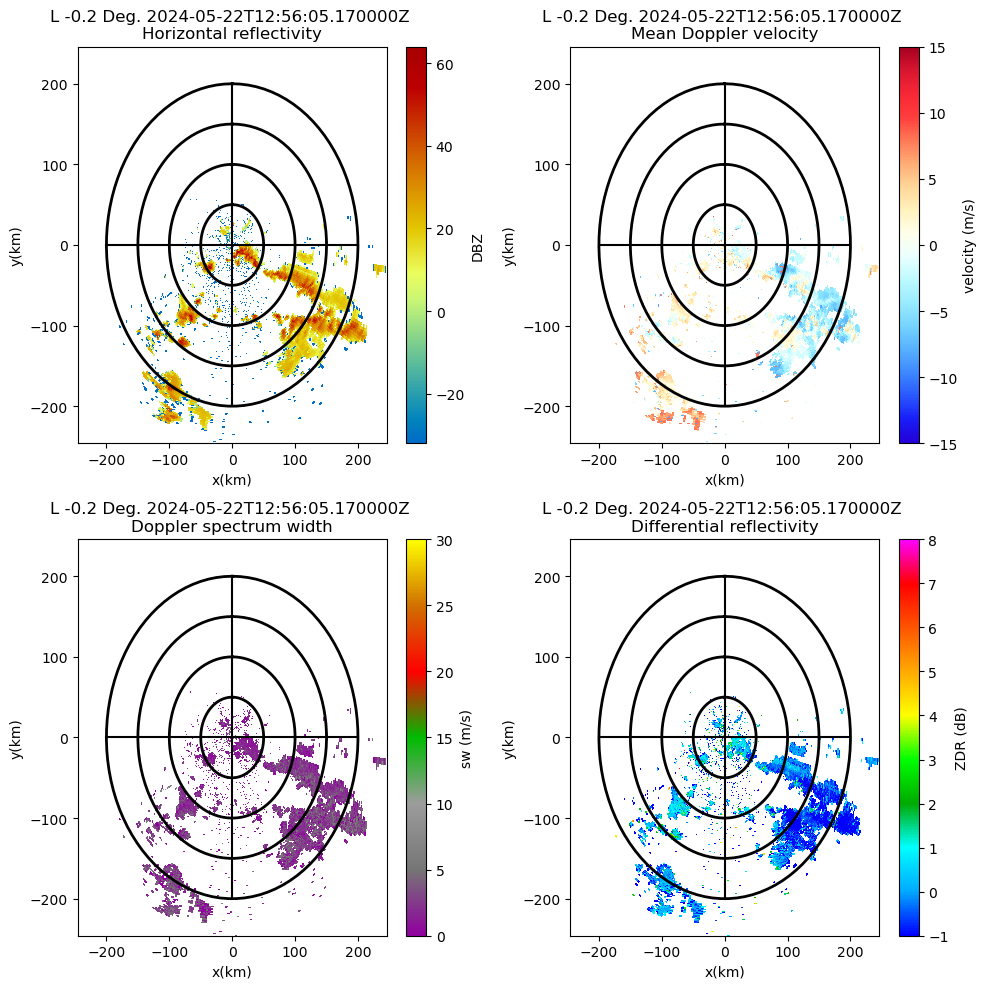

In [15]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(1, (10, 10))

# DBZ

axDbz = fig.add_subplot(221)
display.plot_ppi(
    "reflectivity",
    0,
    vmin=-32,
    vmax=64.0,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="DBZ",
)
display.plot_range_rings([50, 100, 150, 200])
display.plot_cross_hair(200.0)

# velocity

axKdp = fig.add_subplot(222)
display.plot_ppi(
    "velocity",
    0,
    vmin=-15,
    vmax=15,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="velocity (m/s)",
)
display.plot_range_rings([50, 100, 150, 200])
display.plot_cross_hair(200.0)

# spectrum width

axHybrid = fig.add_subplot(223)
display.plot_ppi(
    "spectrum_width", 0, axislabels=("x(km)", "y(km)"), colorbar_label="sw (m/s)"
)
display.plot_range_rings([50, 100, 150, 200])
display.plot_cross_hair(200.0)

# NCAR PID (computed)

axPID = fig.add_subplot(224)
display.plot_ppi(
    "differential_reflectivity",
    0,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="ZDR (dB)",
)
display.plot_range_rings([50, 100, 150, 200])
display.plot_cross_hair(200.0)

fig.tight_layout()
plt.show()

### Plotting Gridded Data with xarray and matplotlib

In [16]:
# Read in example radar mosaic for a single time

filePathGridded = os.path.join("./", "gridded/20240522/ncf_20240522_125944.nc")
dsGridded = xr.open_dataset(filePathGridded)
print("Radar mosaic file path: ", filePathGridded)
print("Radar mosaic data set: ", dsGridded)

# Compute time

start_time = dsGridded["start_time"]
startTimeStr = start_time.dt.strftime("%Y/%m/%d-%H:%M:%S UTC")[0].values
print("Start time: ", startTimeStr)

Radar mosaic file path:  ./gridded/20240522/ncf_20240522_125944.nc
Radar mosaic data set:  <xarray.Dataset> Size: 116MB
Dimensions:                              (time: 1, bounds: 2, x0: 400, y0: 400,
                                          z0: 20)
Coordinates:
  * time                                 (time) datetime64[ns] 8B 2024-05-22T...
  * x0                                   (x0) float32 2kB -199.5 ... 199.5
  * y0                                   (y0) float32 2kB -199.5 ... 199.5
    lat0                                 (y0, x0) float32 640kB ...
    lon0                                 (y0, x0) float32 640kB ...
  * z0                                   (z0) float32 80B 0.5 1.5 ... 18.5 19.5
Dimensions without coordinates: bounds
Data variables: (12/13)
    start_time                           (time) datetime64[ns] 8B ...
    stop_time                            (time) datetime64[ns] 8B ...
    time_bounds                          (time, bounds) datetime64[ns] 16B ...
    grid

In [17]:
minLonMosaic = 7
maxLonMosaic = 11
minLatMosaic = 44.5
maxLatMosaic = 47


# Create map for plotting lat/lon grids
def new_map(fig):

    ## Create projection centered on data
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ## Set extent the same as radar mosaic
    # ax.set_extent([minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic])

    ## Add grid lines & labels:
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="lightgray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {"size": 8, "weight": "bold"}
    gl.ylabel_style = {"size": 8, "weight": "bold"}

    return ax

Text(0.5, 1.0, 'Radar DBZ: 2024/05/22-12:55:01 UTC')

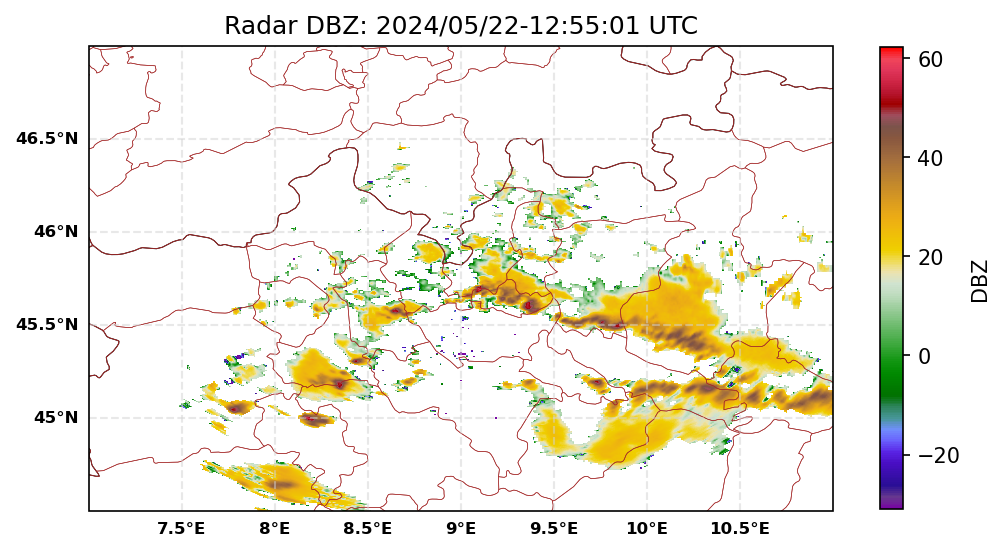

In [18]:
# Plot column-max reflectivity
figDbzComp = plt.figure(figsize=(8, 8), dpi=150)
axDbzComp = new_map(figDbzComp)
plt.imshow(
    dsGridded["reflectivity"].sel(z0=4.5).isel(time=0),
    cmap="pyart_Carbone42",
    interpolation="bilinear",
    origin="lower",
    extent=([minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic]),
)
axDbzComp.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="black")
axDbzComp.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="brown")
# axDbzComp.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="DBZ", orientation="vertical", shrink=0.5)
plt.title("Radar DBZ: " + startTimeStr)

### Hawkeye

FIX LATER - add in pre-canned or command line image

In [19]:
#!${LROSE_DIR}/HawkEye -params hawkeye_auto_gen_images.params -f ./convert/*/*.nc

# Afternoon preview

Want to learn how to run multi-Doppler analysis using FRACTL and SAMURAI? Join us in the afternoon!

### Additional resources

More tutorials can be found on our Gateway GitHub repo: 
https://github.com/nsf-lrose/lrose-hub

The LROSE wiki can be found here:
http://wiki.lrose.net/index.php/Main_Page#

The LROSE forum can be found here:
http://forum.lrose.net/
